# Ordinary Least Squares

Single marker linear regression in statistical genetics explores how a specific genetic variant influences a trait by estimating a linear relationship between the variant's presence and the trait value.

# Graphical Summary

![OLS](./graphical_summary/Slide7.png)

# Key Formula

In the single marker linear regression, $\mathbf{Y} = \mathbf{X} \beta  + \boldsymbol{\epsilon}$,
- $\mathbf{Y}$ is the $N \times 1$ vector of trait values for $N$ individuals
- $\mathbf{X}$ is the $N \times 1$ vector of the genotype vector for a single variant across $N$ individuals
- $\beta$ is the scalar representing the effect size for the single variant (to be estimated)
- $\epsilon$ is the $N \times 1$ vector of error terms for $N$ individuals and $\epsilon \sim N(0, \sigma^2)$

Using **ordinary least squares (OLS)**, we can derive the estimators for $\boldsymbol{\beta}$ in matrix form:

$$
\hat{\beta}_{\text{OLS}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y}
$$


# Technical Details

## Simplified Form for Single Marker
For a single marker regression, the OLS estimator simplifies to:
$$
\hat{\beta}_{\text{OLS}} = \frac{\sum_{i=1}^N x_i y_i}{\sum_{i=1}^N x_i^2}
$$

If genotypes are centered (mean = 0), this becomes the sample covariance divided by sample variance:
$$
\hat{\beta}_{\text{OLS}} = \frac{\text{Cov}(X, Y)}{\text{Var}(X)}
$$

## Statistical Properties

### Unbiasedness
Under the assumption that $E[\boldsymbol{\epsilon}|\mathbf{X}] = 0$:
$$
E[\hat{\beta}_{\text{OLS}}] = \beta
$$

### Variance of the Estimator
$$
\text{Var}(\hat{\beta}_{\text{OLS}}) = \sigma^2 (\mathbf{X}^T\mathbf{X})^{-1} = \frac{\sigma^2}{\sum_{i=1}^N x_i^2}
$$

### Standard Error
$$
\text{SE}(\hat{\beta}_{\text{OLS}}) = \sqrt{\frac{\hat{\sigma}^2}{\sum_{i=1}^N x_i^2}}
$$

where $\hat{\sigma}^2 = \frac{\sum_{i=1}^N (y_i - \hat{y}_i)^2}{N-1}$ is the residual variance estimator.

## Sample Size Requirements

### Mathematical Requirements
- **Absolute minimum**: $N \geq$ number of parameters to estimate
- For single marker regression: $N \geq 2$ (need at least 2 points to fit a line)
- Matrix $\mathbf{X}^T\mathbf{X}$ must be invertible

### Practical Guidelines
- **Reliable estimates**: $N \geq 30$ (general rule of thumb)
- **Stable variance estimates**: $N \geq 20-30$
- Larger $N$ improves estimate quality and reduces uncertainty

# Example

In this example we demonstrate a basic genetic association analysis for height across 5 individuals with 3 genetic variants. (**Note that in practice N<10 is too small for OLS estimates to give reliable results, here is just for illustration.**)

Following the similar framework of simulating the genotype data and standardization, we further assign the phenotype (height) to each individual and standardize the trait value as well. Then we perform single-marker linear regression for each genetic variant using both the `lm` function and the explicit formula we obtained abouve to estimate the OLS effect size. 

In [41]:
# Clear the environment
rm(list = ls())

# Define genotypes for 5 individuals at 3 variants
# These represent actual alleles at each position
# For example, Individual 1 has genotypes: CC, CT, AT
genotypes <- c(
 "CC", "CT", "AT",  # Individual 1
 "TT", "TT", "AA",  # Individual 2
 "CT", "CT", "AA",  # Individual 3
 "CC", "TT", "AA",  # Individual 4
 "CC", "CC", "TT"   # Individual 5
)
# Reshape into a matrix
N = 5 # number of individuals
M = 3 # number of variants
geno_matrix <- matrix(genotypes, nrow=N, ncol=M, byrow=TRUE)
rownames(geno_matrix) <- paste("Individual", 1:N)
colnames(geno_matrix) <- paste("Variant", 1:M)

alt_alleles <- c("T", "C", "T")

# Convert to raw genotype matrix using the additive / dominant / recessive model
Xraw_additive <- matrix(0, nrow=N, ncol=M) # dount number of non-reference alleles

rownames(Xraw_additive) <- rownames(geno_matrix)
colnames(Xraw_additive) <- colnames(geno_matrix)

for (i in 1:N) {
  for (j in 1:M) {
    alleles <- strsplit(geno_matrix[i,j], "")[[1]]
    Xraw_additive[i,j] <- sum(alleles == alt_alleles[j])
  }
}
X <- scale(Xraw_additive, center=TRUE, scale=TRUE)

We observe the heights ($Y$) for the five individuals as follows, and scale $Y$:

In [42]:
# assign observed height for the 5 individuals
Y_raw <- c(180, 160, 158, 155, 193)
Y <- scale(Y_raw)

We perform GWAS analysis on each single SNP using OLS:

In [43]:
p_values <- numeric(M)  # Store p-values
betas <- numeric(M)     # Store estimated effect sizes

for (j in 1:M) {
  SNP <- X[, j]  # Extract genotype for SNP j
  model <- lm(Y ~ SNP)  # OLS regression: Trait ~ SNP
  summary_model <- summary(model)
  
  # Store p-value and effect size (coefficient)
  p_values[j] <- summary_model$coefficients[2, 4]  # p-value for SNP effect
  betas[j] <- summary_model$coefficients[2, 1]     # Estimated beta coefficient
}
# Create results table
OLS_results <- data.frame(Variant = colnames(X), Beta = betas, P_Value = p_values)

The OLS results are:

In [44]:
OLS_results

Variant   Beta       P_Value    
1 Variant 1 -0.5000913 0.390901513
2 Variant 2  0.8525024 0.066475513
3 Variant 3  0.9866667 0.001844466

Or we can use the formula to calculate $\beta$ directly:

In [5]:
# Calculate β̂ for a single SNP explicitly
calculate_beta_ols <- function(Y, X) {
  # β̂ = (X^T X)^(-1) X^T Y
  beta_hat <- solve(t(X) %*% X) %*% t(X) %*% Y
  return(beta_hat)
}

# Perform GWAS-style analysis: Test each SNP independently using OLS
betas_formula <- numeric(M)     # Store estimated effect sizes

for (j in 1:M) {
  betas_formula[j] <- calculate_beta_ols(Y, X[,j, drop=FALSE])
}

In [10]:
OLS_results$beta_from_formula = betas_formula
OLS_results

Variant   Beta       P_Value     beta_from_formula
1 Variant 1 -0.5000913 0.390901513 -0.5000913       
2 Variant 2  0.8525024 0.066475513  0.8525024       
3 Variant 3  0.9866667 0.001844466  0.9866667

# Supplementary

Here we calculate the OLS estimate for joint effects (instead of marginal effects)

## Joint Effects

In [67]:
# Perform linear regression with all variants
joint_model <- lm(Y ~ X[,1] + X[,2] + X[,3])
# Summary of the regression
summary(joint_model)


Call:
lm(formula = Y ~ X[, 1] + X[, 2] + X[, 3])

Residuals:
         1          2          3          4          5 
 2.418e-01 -2.776e-17  4.163e-17 -1.209e-01 -1.209e-01 
attr(,"scaled:center")
[1] 169.2
attr(,"scaled:scale")
[1] 16.54

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)  6.886e-16  1.324e-01   0.000    1.000
X[, 1]       8.110e-02  1.793e-01   0.452    0.730
X[, 2]      -2.529e-02  2.992e-01  -0.085    0.946
X[, 3]       1.054e+00  3.198e-01   3.296    0.188

Residual standard error: 0.2961 on 1 degrees of freedom
Multiple R-squared:  0.9781,	Adjusted R-squared:  0.9123 
F-statistic: 14.87 on 3 and 1 DF,  p-value: 0.1878


In [68]:
# or we calculate from formula directly
beta_hat_OLS <- solve(t(X) %*% X) %*% t(X) %*% Y  # OLS formula without intercept
print("OLS Solution (for joint effects using formula):")
print(beta_hat_OLS)

[1] "OLS Solution (for joint effects using formula):"
                 [,1]
Variant 1  0.08109589
Variant 2 -0.02528609
Variant 3  1.05424659


## Graphical Summary

Estimated slope (<U+03B2><U+2081>): 1.02 


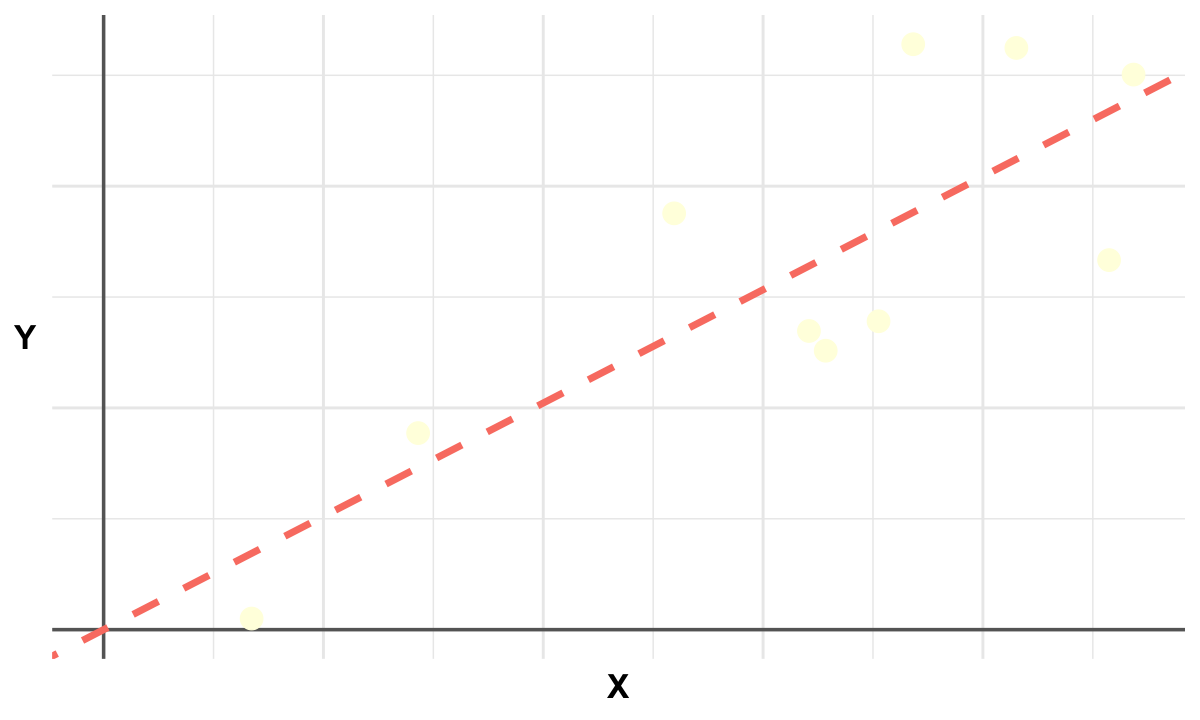

In [64]:
# Load necessary library
library(ggplot2)

# Set plot size (for Jupyter or RMarkdown)
options(repr.plot.width = 10, repr.plot.height = 6)

# Generate positive example data
set.seed(42)
x <- runif(10, min = 0, max = 5)  # Positive x values
y <- 0.5 * x + rnorm(10, mean = 0, sd = 1)
y <- y - min(y) + 0.1  # Ensure y is positive
data <- data.frame(x = x, y = y)

# Fit linear model through the origin
model <- lm(y ~ 0 + x, data = data)  # No intercept
beta1 <- coef(model)[1]
cat("Estimated slope (β₁):", round(beta1, 2), "\n")

# Plot
p <- ggplot(data, aes(x = x, y = y)) +
  geom_hline(yintercept = 0, color = "gray40", linewidth = 1) +
  geom_vline(xintercept = 0, color = "gray40", linewidth = 1) +
  geom_point(color = "lightyellow", size = 6) +  # yellow points
  geom_abline(intercept = 0, slope = beta1, color = "salmon", linetype = "dashed", linewidth = 2) +
  labs(x = "X", y = "Y") +
  theme_minimal(base_size = 18) +
  theme(
    plot.title = element_blank(),  # no title
    axis.title = element_text(size = 20, face = "bold"),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title.y = element_text(angle = 0, vjust = 0.5)  # horizontal Y label
  )
print(p)

# Save with transparent background
ggsave("cartoons/ordinary_least_squares.png", plot = p, 
       width = 10, height = 6, 
       bg = "transparent", 
       dpi = 300)
